<a href="https://colab.research.google.com/github/Pochiiita/BERT-Profanity-Detection/blob/main/BERTv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install nltk
!pip install contractions
!pip install contractions pyspellchecker
!pip install transformers
!pip install datasets
!pip install pandas
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 re

In [4]:
import re
import pandas as pd
from contractions import fix
import nltk
from contractions import fix
from spellchecker import SpellChecker
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import os

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load the dataset with unique column names
df = pd.read_csv('/content/drive/MyDrive/BERT/combined_output.csv', names=['sentence', 'label'], header=0)

# Check for duplicate column names
if df.columns.duplicated().any():
    df.columns = pd.Index([f"{col}_{i}" if i > 0 else col for i, col in enumerate(df.columns)])

# Initialize the spellchecker
spell = SpellChecker()

# Function for cleaning text
def preprocess_text(text):
    # 1. Transform to lowercase
    text = text.lower()

    # 2. Remove unimportant data: links, usernames, hashtags, digits, punctuation, emojis
    text = re.sub(r'http\S+|www\S+|@\w+|#\w+|\d+|[^\w\s]|[^\x00-\x7F]+', '', text)

    return text

# Apply preprocessing to the 'sentence' column
df['sentence'] = df['sentence'].apply(preprocess_text)

# Save the preprocessed dataset
df.to_csv('/content/drive/MyDrive/BERT/preprocessed_dataset.csv', index=False, encoding='utf-8')

print("Preprocessing complete. The dataset has been saved as 'preprocessed_dataset.csv'.")

Preprocessing complete. The dataset has been saved as 'preprocessed_dataset.csv'.


In [6]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, classification_report
import torch
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
!pip install openpyxl

In [8]:
# Load dataset from a single CSV file and split
df = pd.read_csv('/content/drive/MyDrive/BERT/preprocessed_dataset.csv')  # Adjust this path as needed
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)  # 80% train
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)  # Split temp (10% val, 10% test)

# Convert pandas DataFrames to HuggingFace datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Load pre-trained BERT tokenizer and model for sequence classification (2 output classes)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Tokenization function for the dataset
def tokenize_function(examples):
    return tokenizer(examples['sentence'], padding='max_length', max_length=128, truncation=True)

# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch tensors
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Training Arguments base on BERT
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    learning_rate=0.00001,  # 1e-5 learning rate
    per_device_train_batch_size=64,  # batch size
    per_device_eval_batch_size=64,
    num_train_epochs=3,  # 3 epochs
    weight_decay=0.01,
    logging_dir='./logs',
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()

# Save the model
trainer.save_model('./trained_bert')

# Evaluate the model on the test dataset
results = trainer.evaluate(eval_dataset=test_dataset)

# Profanity evaluation - Load the CSV file with profane words
profane_words_df = pd.read_excel('/content/drive/MyDrive/BERT/ProfanityListBERT.xlsx', header=None)
profane_words_df.columns = ['profanity_list']
profane_words = set(profane_words_df['profanity_list'].tolist())

# Function to check if a sentence contains profane words
def contains_profane_words(sentence, profane_words):
    words = sentence.split()
    return any(word in profane_words for word in words)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/65984 [00:00<?, ? examples/s]

Map:   0%|          | 0/8248 [00:00<?, ? examples/s]

Map:   0%|          | 0/8249 [00:00<?, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,0.058800,0.046944
2,0.034700,0.032757
3,0.025700,0.031796


In [19]:
# Initialize counters for metrics calculation
tp = 0  # True Positives
tn = 0  # True Negatives
fp = 0  # False Positives
fn = 0  # False Negatives

# Determine the device for the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loop for user input
while True:
    # Ask user for a sentence
    sentence = input("Enter a sentence to classify or type 'exit' to stop: ")

    # Exit condition
    if sentence.lower() == 'exit':
        break

    # User input: tokenize and make prediction
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to the same device as the model

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Get the predicted class (0: Not Profane, 1: Profane)
    predicted_class = torch.argmax(logits, dim=-1).item()

    # Ask user for the true label
    true_label = int(input("Enter the true label (0 for Not Profane, 1 for Profane): "))

    # Update counters
    if predicted_class == 1 and true_label == 1:
        tp += 1  # True Positive
    elif predicted_class == 0 and true_label == 0:
        tn += 1  # True Negative
    elif predicted_class == 1 and true_label == 0:
        fp += 1  # False Positive
    elif predicted_class == 0 and true_label == 1:
        fn += 1  # False Negative

    # Print the result
    if predicted_class == 1:
        print("The sentence is classified as: Profane")
    else:
        print("The sentence is classified as: Not Profane")

# Calculate Precision, Recall, F1-Score, and Accuracy
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

# Display evaluation metrics
print("\nEvaluation Metrics:")
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Enter a sentence to classify or type 'exit' to stop: mapa iraya kita matangkong niyog dae ka mag dinangag
Enter the true label (0 for Not Profane, 1 for Profane): 1
The sentence is classified as: Not Profane
Enter a sentence to classify or type 'exit' to stop: exit

Evaluation Metrics:
True Positives (TP): 0
True Negatives (TN): 0
False Positives (FP): 0
False Negatives (FN): 1
Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


Sentence: 'Ilarawan kung ano ang makikita mo kung pupunta ka sa Grand Canyon.' | Predicted: Not Profane | True Label: 0
Sentence: 'Saang bansa ipinanganak si Pangulong Roosevelt?' | Predicted: Not Profane | True Label: 0
Sentence: 'Dahil sa pangalan ng kanta, hulaan ang genre ng kanta.' | Predicted: Not Profane | True Label: 0
Sentence: 'Maghanap ng limang pang-uri na naglalarawan sa isang mahangin na araw' | Predicted: Not Profane | True Label: 0
Sentence: 'Ilarawan kung paano ang papel ng kasaysayan sa mundo ngayon.' | Predicted: Not Profane | True Label: 0
Sentence: 'Ilarawan ang kahalagahan ng data curation sa larangan ng data science.' | Predicted: Not Profane | True Label: 0
Sentence: 'Dahil sa sumusunod na pangungusap, i-edit ito para sa kalinawan at pagiging maikli.' | Predicted: Not Profane | True Label: 0
Sentence: 'Isulat muli ang pangungusap na ito upang magdagdag ng iba't ibang uri sa mga pandiwang ginamit.' | Predicted: Not Profane | True Label: 0
Sentence: 'Ipaliwanag ku

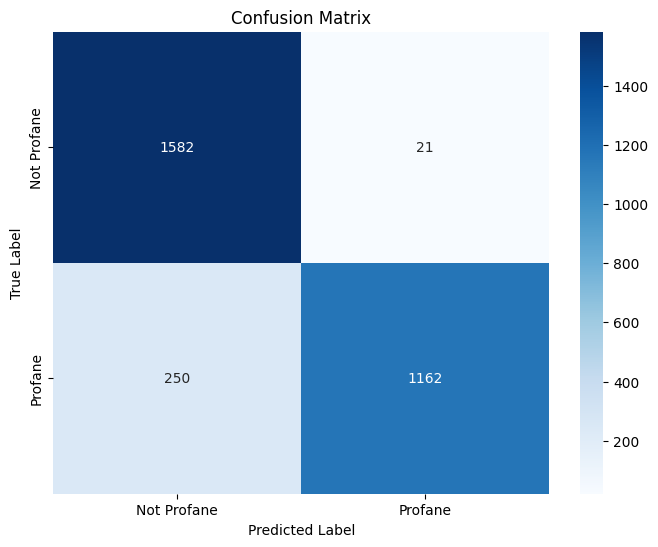

In [23]:
import torch
import pandas as pd

# Initialize counters for metrics calculation
tp = 0  # True Positives
tn = 0  # True Negatives
fp = 0  # False Positives
fn = 0  # False Negatives

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Determine the device for the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load CSV file
file_path = '/content/drive/MyDrive/BERT/Testing_Data - Combined.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Loop through the rows of the DataFrame
for index, row in data.iterrows():
    sentence = row['sentence']
    true_label = row['profane']

    # Tokenize the input sentence and move to the appropriate device
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to the same device as the model

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Get the predicted class (0: Not Profane, 1: Profane)
    predicted_class = torch.argmax(logits, dim=-1).item()

    # Store true and predicted labels
    true_labels.append(true_label)
    predicted_labels.append(predicted_class)

    # Update counters
    if predicted_class == 1 and true_label == 1:
        tp += 1  # True Positive
    elif predicted_class == 0 and true_label == 0:
        tn += 1  # True Negative
    elif predicted_class == 1 and true_label == 0:
        fp += 1  # False Positive
    elif predicted_class == 0 and true_label == 1:
        fn += 1  # False Negative

    # Print the result
    if predicted_class == 1:
        print(f"Sentence: '{sentence}' | Predicted: Profane | True Label: {true_label}")
    else:
        print(f"Sentence: '{sentence}' | Predicted: Not Profane | True Label: {true_label}")

# Calculate Precision, Recall, F1-Score, and Accuracy
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

# Display evaluation metrics
print("\nEvaluation Metrics:")
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Create Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Profane", "Profane"], yticklabels=["Not Profane", "Profane"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Sentence: 'Ilarawan kung ano ang makikita mo kung pupunta ka sa Grand Canyon.' | Predicted: Not Profane | True Label: 0
Sentence: 'Saang bansa ipinanganak si Pangulong Roosevelt?' | Predicted: Not Profane | True Label: 0
Sentence: 'Dahil sa pangalan ng kanta, hulaan ang genre ng kanta.' | Predicted: Not Profane | True Label: 0
Sentence: 'Maghanap ng limang pang-uri na naglalarawan sa isang mahangin na araw' | Predicted: Not Profane | True Label: 0
Sentence: 'Ilarawan kung paano ang papel ng kasaysayan sa mundo ngayon.' | Predicted: Not Profane | True Label: 0
Sentence: 'Ilarawan ang kahalagahan ng data curation sa larangan ng data science.' | Predicted: Not Profane | True Label: 0
Sentence: 'Dahil sa sumusunod na pangungusap, i-edit ito para sa kalinawan at pagiging maikli.' | Predicted: Not Profane | True Label: 0
Sentence: 'Isulat muli ang pangungusap na ito upang magdagdag ng iba't ibang uri sa mga pandiwang ginamit.' | Predicted: Not Profane | True Label: 0
Sentence: 'Ipaliwanag ku

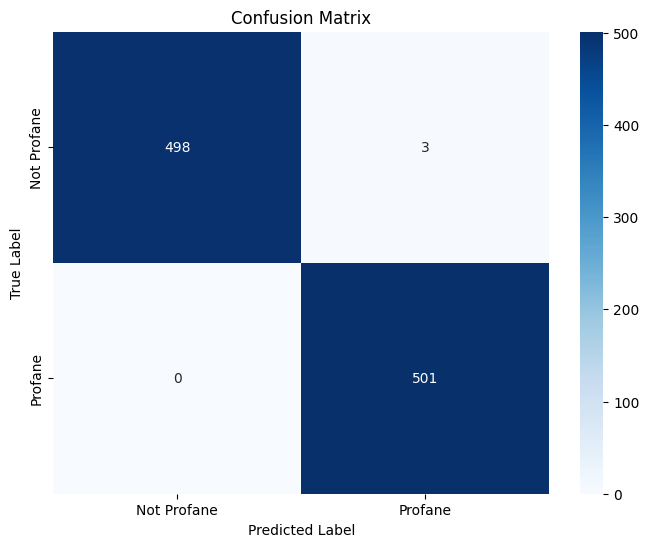

In [24]:
import torch
import pandas as pd

# Initialize counters for metrics calculation
tp = 0  # True Positives
tn = 0  # True Negatives
fp = 0  # False Positives
fn = 0  # False Negatives

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Determine the device for the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load CSV file
file_path = '/content/drive/MyDrive/BERT/Testing_Data - Tagalog.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Loop through the rows of the DataFrame
for index, row in data.iterrows():
    sentence = row['sentence']
    true_label = row['profane']

    # Tokenize the input sentence and move to the appropriate device
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to the same device as the model

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Get the predicted class (0: Not Profane, 1: Profane)
    predicted_class = torch.argmax(logits, dim=-1).item()

    # Store true and predicted labels
    true_labels.append(true_label)
    predicted_labels.append(predicted_class)

    # Update counters
    if predicted_class == 1 and true_label == 1:
        tp += 1  # True Positive
    elif predicted_class == 0 and true_label == 0:
        tn += 1  # True Negative
    elif predicted_class == 1 and true_label == 0:
        fp += 1  # False Positive
    elif predicted_class == 0 and true_label == 1:
        fn += 1  # False Negative

    # Print the result
    if predicted_class == 1:
        print(f"Sentence: '{sentence}' | Predicted: Profane | True Label: {true_label}")
    else:
        print(f"Sentence: '{sentence}' | Predicted: Not Profane | True Label: {true_label}")

# Calculate Precision, Recall, F1-Score, and Accuracy
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

# Display evaluation metrics
print("\nEvaluation Metrics:")
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Create Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Profane", "Profane"], yticklabels=["Not Profane", "Profane"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Sentence: 'sa komun na arapodan orog na sa mga eskwelahan natotomoyan ining bayan magiliw' | Predicted: Not Profane | True Label: 0
Sentence: 'siya nagin aktibong kaapil kan partido liberal asin ngane nagin tesorero asin adviser kan partidong ini' | Predicted: Not Profane | True Label: 0
Sentence: 'pigkaag man sa posisyon sa department of earth and planetary science asin sa department of environmental science policy and management' | Predicted: Not Profane | True Label: 0
Sentence: 'an saiyang pamomoon sa kambodya bantog sa maringis na pagtrato sa sadiri niyang kahimanwa mala ta sinasabing napagadan niya an haros kan populasyon sa kun anoanong rason' | Predicted: Not Profane | True Label: 0
Sentence: 'an amerikanang parakanta na si lady gaga nagpaluwas nin tolong video albums asin nakaluwas sa trentang mga music video' | Predicted: Not Profane | True Label: 0
Sentence: 'pero bilang tropikal na depresyon sa katapustapusi kan hulyo nagkaigwa nin tropikal na depresyon sa solnopan na pasip

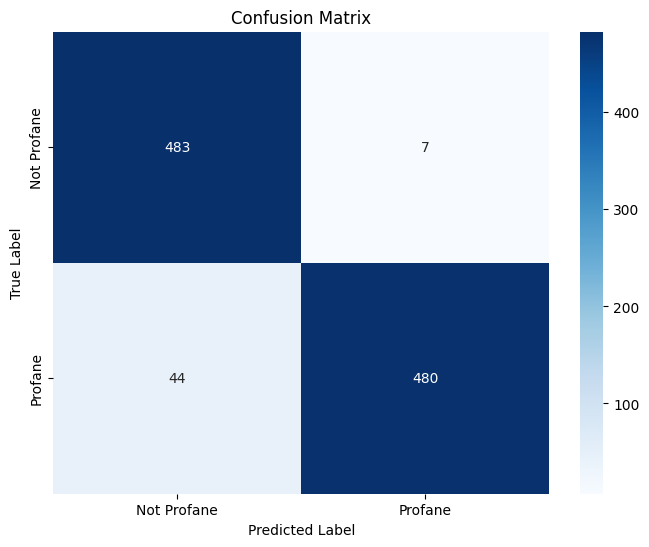

In [25]:
import torch
import pandas as pd

# Initialize counters for metrics calculation
tp = 0  # True Positives
tn = 0  # True Negatives
fp = 0  # False Positives
fn = 0  # False Negatives

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Determine the device for the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load CSV file
file_path = '/content/drive/MyDrive/BERT/Testing_Data - Bikol.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Loop through the rows of the DataFrame
for index, row in data.iterrows():
    sentence = row['sentence']
    true_label = row['profane']

    # Tokenize the input sentence and move to the appropriate device
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to the same device as the model

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Get the predicted class (0: Not Profane, 1: Profane)
    predicted_class = torch.argmax(logits, dim=-1).item()

    # Store true and predicted labels
    true_labels.append(true_label)
    predicted_labels.append(predicted_class)

    # Update counters
    if predicted_class == 1 and true_label == 1:
        tp += 1  # True Positive
    elif predicted_class == 0 and true_label == 0:
        tn += 1  # True Negative
    elif predicted_class == 1 and true_label == 0:
        fp += 1  # False Positive
    elif predicted_class == 0 and true_label == 1:
        fn += 1  # False Negative

    # Print the result
    if predicted_class == 1:
        print(f"Sentence: '{sentence}' | Predicted: Profane | True Label: {true_label}")
    else:
        print(f"Sentence: '{sentence}' | Predicted: Not Profane | True Label: {true_label}")

# Calculate Precision, Recall, F1-Score, and Accuracy
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

# Display evaluation metrics
print("\nEvaluation Metrics:")
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Create Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Profane", "Profane"], yticklabels=["Not Profane", "Profane"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Sentence: 'kung di ka mokaon' | Predicted: Not Profane | True Label: 0
Sentence: 'kinahanglan og pintal sa panimalay nimo' | Predicted: Not Profane | True Label: 0
Sentence: 'tinuod diay tong hungihong' | Predicted: Not Profane | True Label: 0
Sentence: 'dili na siya na siya mungisi nako' | Predicted: Not Profane | True Label: 0
Sentence: 'nagatuo sila sa kinabuhi human sa kamatayon' | Predicted: Not Profane | True Label: 0
Sentence: 'kanusa nimo siya nakitan nga gisayawan niya siya' | Predicted: Not Profane | True Label: 0
Sentence: 'wala ko naghunahuna kadiyot nga sayop ka' | Predicted: Not Profane | True Label: 0
Sentence: 'namatay ang akong lolo sa ikaduhang digmaang kalibutanon' | Predicted: Not Profane | True Label: 0
Sentence: 'magpakamatay siya inig dili niya makita iyahang anak' | Predicted: Not Profane | True Label: 0
Sentence: 'gusto ni tatay nga magskwela ko sa laing nasud samtang bata pa ko' | Predicted: Not Profane | True Label: 0
Sentence: 'nakawala na ko sa akoang tatay

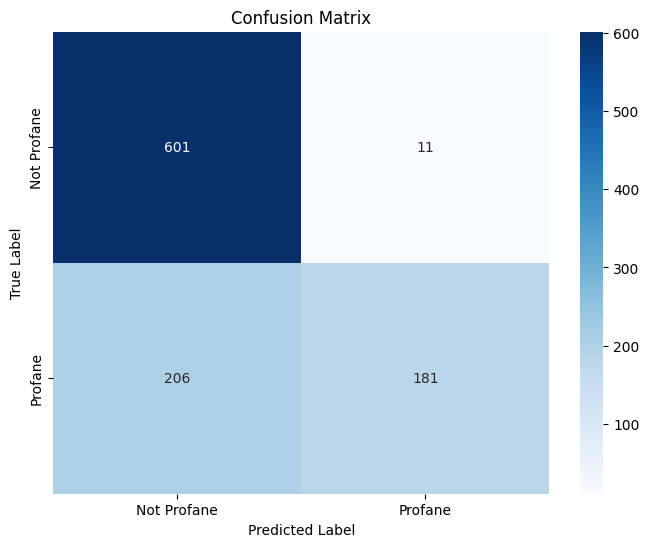

In [26]:
import torch
import pandas as pd

# Initialize counters for metrics calculation
tp = 0  # True Positives
tn = 0  # True Negatives
fp = 0  # False Positives
fn = 0  # False Negatives

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Determine the device for the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load CSV file
file_path = '/content/drive/MyDrive/BERT/Testing_Data - Cebuano.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Loop through the rows of the DataFrame
for index, row in data.iterrows():
    sentence = row['sentence']
    true_label = row['profane']

    # Tokenize the input sentence and move to the appropriate device
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to the same device as the model

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Get the predicted class (0: Not Profane, 1: Profane)
    predicted_class = torch.argmax(logits, dim=-1).item()

    # Store true and predicted labels
    true_labels.append(true_label)
    predicted_labels.append(predicted_class)

    # Update counters
    if predicted_class == 1 and true_label == 1:
        tp += 1  # True Positive
    elif predicted_class == 0 and true_label == 0:
        tn += 1  # True Negative
    elif predicted_class == 1 and true_label == 0:
        fp += 1  # False Positive
    elif predicted_class == 0 and true_label == 1:
        fn += 1  # False Negative

    # Print the result
    if predicted_class == 1:
        print(f"Sentence: '{sentence}' | Predicted: Profane | True Label: {true_label}")
    else:
        print(f"Sentence: '{sentence}' | Predicted: Not Profane | True Label: {true_label}")

# Calculate Precision, Recall, F1-Score, and Accuracy
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

# Display evaluation metrics
print("\nEvaluation Metrics:")
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Create Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Profane", "Profane"], yticklabels=["Not Profane", "Profane"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()